<a href="https://colab.research.google.com/github/sergejhorvat/TensorFlow-in-Practice---Coursera/blob/master/Sequences%2C%20Time%20Series%20and%20Prediction/S%2BP_Week_4_Exercise_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install tensorflow-gpu==2.0.0

In [5]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-01-01 22:53:42--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2020-01-01 22:53:42 (4.62 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



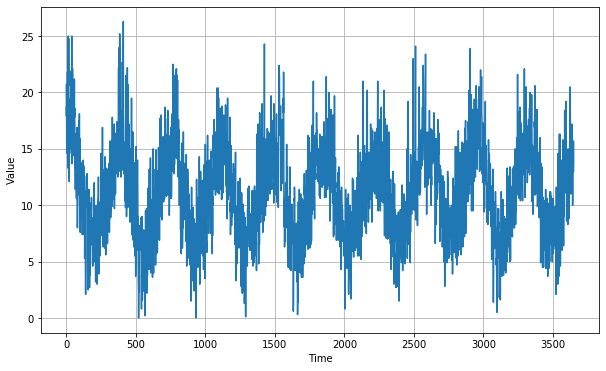

In [7]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
    reader = csv.reader(csvfile, delimiter=',')
    next(reader) # skip first row with column names
    index = 0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(int(index))
        index = index + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train =  series[:split_time]# YOUR CODE HERE
time_valid = time[split_time:]# YOUR CODE HERE
x_valid = series[split_time:]# YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)

])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 4s 418ms/step - loss: 31.1549 - mae: 31.6551
Epoch 2/100
10/10 [==============================] - 1s 71ms/step - loss: 30.5753 - mae: 31.0783
Epoch 3/100
10/10 [==============================] - 1s 72ms/step - loss: 29.7469 - mae: 30.1792
Epoch 4/100
10/10 [==============================] - 1s 73ms/step - loss: 28.5816 - mae: 29.0582
Epoch 5/100
10/10 [==============================] - 1s 67ms/step - loss: 27.1349 - mae: 27.6970
Epoch 6/100
10/10 [==============================] - 1s 76ms/step - loss: 25.5287 - mae: 25.9975
Epoch 7/100
10/10 [==============================] - 1s 74ms/step - loss: 23.3412 - mae: 23.8407
Epoch 8/100
10/10 [==============================] - 1s 70ms/step - loss: 20.6980 - mae: 21.1120
Epoch 9/100
10/10 [==============================] - 1s 71ms/step - loss: 17.4437 - mae: 17.8083
Epoch 10/100
10/10 [====

[1e-08, 0.0001, 0, 60]

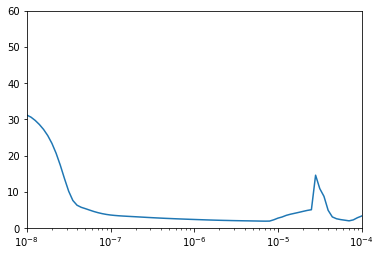

In [28]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [29]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200) # YOUR CODE HERE
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/200
25/25 [==============================] - 4s 177ms/step - loss: 4.9911 - mae: 5.5220
Epoch 2/200
25/25 [==============================] - 1s 31ms/step - loss: 2.2560 - mae: 2.7095
Epoch 3/200
25/25 [==============================] - 1s 33ms/step - loss: 1.8609 - mae: 2.3143
Epoch 4/200
25/25 [==============================] - 1s 33ms/step - loss: 1.7616 - mae: 2.2130
Epoch 5/200
25/25 [==============================] - 1s 33ms/step - loss: 1.7313 - mae: 2.1806
Epoch 6/200
25/25 [==============================] - 1s 36ms/step - loss: 1.7012 - mae: 2.1504
Epoch 7/200
25/25 [==============================] - 1s 32ms/step - loss: 1.6805 - mae: 2.1290
Epoch 8/200
25/25 [==============================] - 1s 34ms/step - loss: 1.6708 - mae: 2.1182
Epoch 9/200
25/25 [==============================] - 1s 33ms/step - loss: 1.6581 - mae: 2.1045
Epoch 10/200
25/25 [==============================] - 1s 34ms/step - loss: 1.6783 - mae: 2.1247
Epoch 11/200
25/25 [============================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

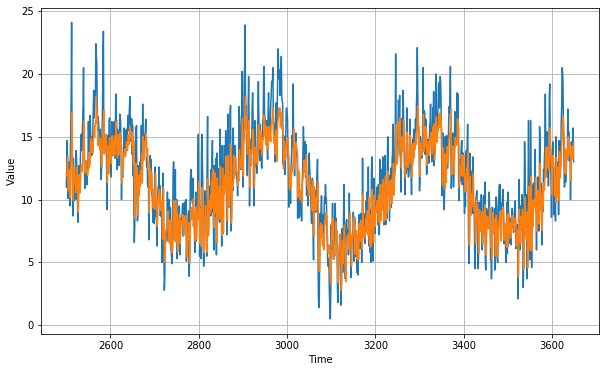

In [31]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [32]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.8443614

In [33]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.9827385 11.886492  12.634534  ... 13.234739  13.297786  14.509541 ]
